<br>

# Molecular Dynamics and Ab Initio Simulations : Developing a Predictive Model for Molecular Energy Configurations

## Table of contents:

* [First view on data](#first-view-on-data)
    * [MO2S4 dataset](#mo2s4-dataset)
    * [Zundel dataset](#zundel-dataset)
* [Data Preprocessing](#data-preprocessing)
    * [Naive and linear regression model](#naive-and-linear-regression-model)
        * [Naive model](#naive-model)
        * [Linear regression model](#linear-regression-model)
        * [Again with Zundel Ions](#again-with-zundel-ions)
    * [Describing the data with other representations](#describing-the-data-with-other-representations)
        * [Coulomb matrix](#coulomb-matrix)
        * [Ewald sum matrix](#ewald-sum-matrix)


This project involves utilizing results from ab initio molecular dynamics simulations to develop a model capable of predicting the energy associated with specific molecular configurations. It leverages two datasets: the first encompasses simulations on the dynamics of the Zundel ion (H2O-H-H2O), while the second focuses on a Mo2S4 aggregate. Each dataset contains about 10,000 atomic configurations and their corresponding potential energies, providing a comprehensive basis for accurate energy prediction in molecular systems.

<br>

<br>

## First view on data <a class="anchor" id="first-view-on-data"></a>

### MO2S4 dataset <a class="anchor" id="mo2s4-dataset"></a>

First, let's try to render a configuration on a 3D plot. We will first look into the MO2S4 dataset by plotting the first and last configurations.

<br>

In [1]:
%matplotlib inline

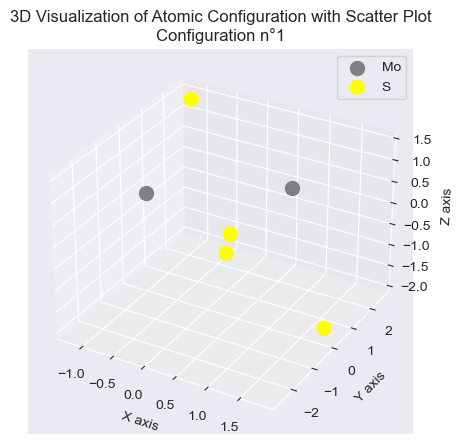

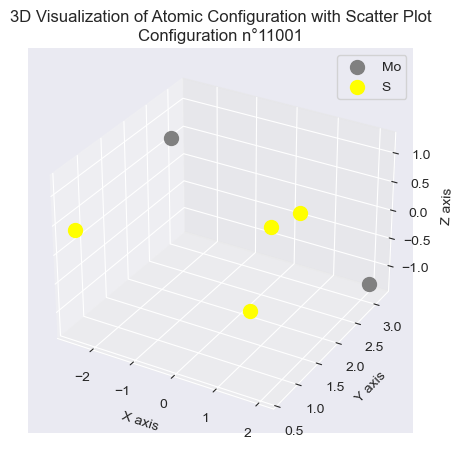

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MO2S4_file_path = 'data/MO2S4/TRAJEC_short.xyz'

# Re-reading the file to confirm its structure
with open(MO2S4_file_path, 'r') as file:
    MO2S4_file_content = file.readlines()

# Parsing the first configuration from the file
# Skipping the first two lines (number of atoms and comment) and taking the next six lines for the first configuration

def plot_configuration_MO2S4(first_line, last_line):

    configuration = MO2S4_file_content[first_line:last_line]

    # Extracting atom types and their positions
    atom_types = []
    positions = []

    for line in configuration:
        parts = line.split()
        atom_types.append(parts[0])  # Atom type (Mo or S)
        positions.append([float(parts[1]), float(parts[2]), float(parts[3])])  # x, y, z coordinates

    positions = np.array(positions)

    # Creating a 3D scatter plot using 'o' markers to represent atoms
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting each atom with 'o' marker
    for i, atom in enumerate(atom_types):
        x, y, z = positions[i]
        color = 'gray' if atom == 'Mo' else 'yellow'  # Gray for Mo, Yellow for S
        ax.scatter(x, y, z, c=color, marker='o', s=100)  # Adjust size as needed

    # Adding labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Add legend
    ax.scatter([], [], [], c='gray', marker='o', s=100, label='Mo')
    ax.scatter([], [], [], c='yellow', marker='o', s=100, label='S')
    ax.legend()

    # Add a title


    plt.title('3D Visualization of Atomic Configuration with Scatter Plot\nConfiguration n°' + str(last_line//8))
    plt.savefig('img/visualisation_3D/config_MO2S4_' + str(last_line//8) + '.png', dpi=200)
    plt.show()

plot_configuration_MO2S4(2,8)
plot_configuration_MO2S4(88002,88008)

<br>

We can check these configurations with an image from Jmol:

<br>

#### First configuration :

![image](img/visualisation_3D/first_config_MO2S4.png)
<br>

#### Last configuration :

![image](img/visualisation_3D/last_config_MO2S4.png)

<br>

We can see the plotting are correct (even tho there is a slight difference in the position of the atoms, but it is due to the fact that the Jmol image is not in the exact same orientation as the plotting).

<br>


We notice that the configurations are quite different.

Properties of ``TRAJEC_short.xyz`` :
- 11,001 configurations (88,008 lines/8 lines per configuration).
- No units for positions, but it can be assumed that they are in Angstroms ($\AA = 10^-{10}m$).

It is quickly noticed that there are 11,001 lines in the ``energies.out`` file, and the same in the ``potential-energy`` file. It seems that the values in ``potential-energy.txt`` correspond to those in ``energies.out``. We can then verify this:

<br>

In [3]:
MO2S4_energies_out = pd.read_csv("data/MO2S4/energies.out", delim_whitespace=True)
MO2S4_energies_out.head()

,step,none,temp,potential_energy,none.1,none.2,none.3,none.4
0,1,0.00000000,1278.492,-176.957259,-176.893668,0.0,0.000062,1.31
1,5,0.00000000,8620.471,-176.992785,-175.702624,0.0,0.036543,1.56
2,10,0.00000000,954.638,-176.996302,-175.624659,0.0,0.095147,0.84
3,15,0.00000000,319.990,-176.997355,-175.621132,0.0,0.121177,1.05
4,20,0.00000000,273.078,-177.004502,-175.619745,0.0,0.137373,1.32


In [4]:
MO2S4_potential_energy = pd.read_csv('data/MO2S4/potential-energy.txt', delim_whitespace=True, header=None)
MO2S4_potential_energy.columns = ['potential_energy']
MO2S4_potential_energy.head()
MO2S4_potential_energy.describe()

,potential_energy
count,11001.000000
mean,-174.781684
std,32.382531
min,-177.227754
25%,-176.907018
50%,-176.649494
75%,-176.292903
max,633.486070


In [5]:
# On teste si les deux colonnes sont égales
print(MO2S4_energies_out['potential_energy'].equals(MO2S4_potential_energy['potential_energy']))

True


<br>


The two columns quickly lead us to assume that the ``energies.out`` file represents the energies of the 11,001 configurations in the ``TRAJEC_short.xyz`` file. We can then simply use the energies.out file to train our model.

<br>

### Zundel dataset <a class="anchor" id="zundel-dataset"></a>

<br>

This dataset is composed of only two files, ``new_energies_sparse.out`` and ``new_positions_sparse.xyz``. We can directly see that these two files are, resp., the energy table we saw on ``energies.out`` and the ``TRAJEC_short.xyz``. Let's import them and look the same way as the MO2S4.

<br>


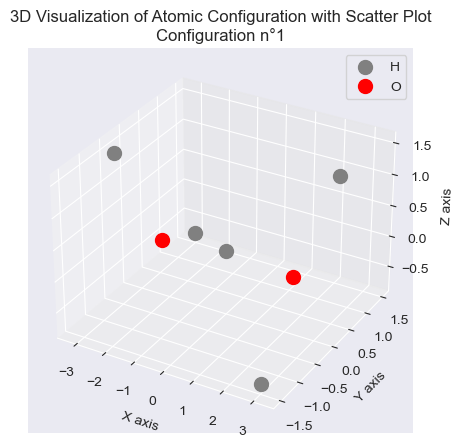

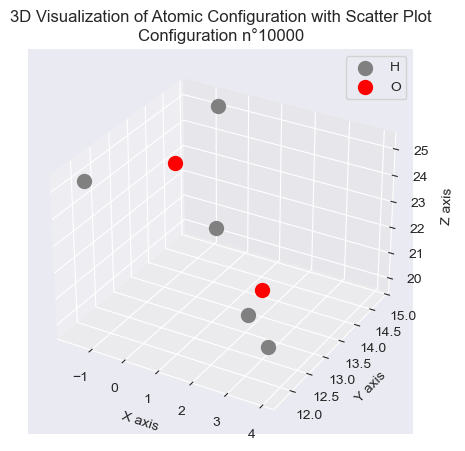

In [6]:
zundel_file_path = 'data/zundel_ions/new_positions_sparse.xyz'

# Re-reading the file to confirm its structure
with open(zundel_file_path, 'r') as file:
    zundel_file_content = file.readlines()

# Parsing the first configuration from the file
# Skipping the first two lines (number of atoms and comment) and taking the next six lines for the first configuration

def plot_configuration_zundel(first_line, last_line):

    configuration = zundel_file_content[first_line:last_line]

    # Extracting atom types and their positions
    atom_types = []
    positions = []

    for line in configuration:
        parts = line.split()
        atom_types.append(parts[0])  # Atom type (O or H)
        positions.append([float(parts[1]), float(parts[2]), float(parts[3])])  # x, y, z coordinates

    positions = np.array(positions)

    # Creating a 3D scatter plot using 'o' markers to represent atoms
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting each atom with 'o' marker
    for i, atom in enumerate(atom_types):
        x, y, z = positions[i]
        color = 'red' if atom == 'O' else 'gray'  # Gray for H, Red for O
        ax.scatter(x, y, z, c=color, marker='o', s=100)  # Adjust size as needed

    # Adding labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Add legend
    ax.scatter([], [], [], c='gray', marker='o', s=100, label='H')
    ax.scatter([], [], [], c='red', marker='o', s=100, label='O')
    ax.legend()

    # Add a title

    plt.title('3D Visualization of Atomic Configuration with Scatter Plot\nConfiguration n°' + str(last_line//9))
    plt.savefig('img/visualisation_3D/config_Zundel_' + str(last_line//9) + '.png', dpi=200)
    plt.show()


plot_configuration_zundel(2,9)
plot_configuration_zundel(89993,90000)

<br>

Again, we can check these configurations with an image from Jmol:

<br>

#### First configuration :

![image](img/visualisation_3D/first_config_zundel.png)
<br>

#### Last configuration :

![image](img/visualisation_3D/last_config_zundel.png)

<br>

We see that ...

<br>

Now let's check the table of energies:

In [7]:
# uniquement prendre la 5ème colonne
zundel_potential_energy = pd.read_csv('data/zundel_ions/new_energies_sparse.out', delim_whitespace=True, header=None, usecols=[4], names=['potential_energy'])
zundel_potential_energy.head()
#describe but with scientific notation
pd.set_option('display.float_format', lambda x: '%.2e' % x)
zundel_potential_energy.describe()

,potential_energy
count,1.00e+04
mean,2.54e-03
std,9.10e-04
min,9.59e-05
25%,1.88e-03
50%,2.43e-03
75%,3.08e-03
max,7.21e-03


## Data Preprocessing <a class="anchor" id="data-preprocessing"></a>

<br>

The goal here is to describe the data and to prepare it for the model. Indeed, we will try to directly use the data as it is, without any preprocessing and use a naive model, and then we will try to preprocess it to see if it improves the model.

<br>

### Naive and linear regression model <a class="anchor" id="naive-and-linear-regression-model"></a>

<br>

We will first try to use the data as it is, without any preprocessing. By this, I mean we will use the coordinates of the atoms as features and the potential energy as the target. Then, we will use the mean of the potential energy as a naive model to predict the potential energy of a configuration and check the score of this model.

In [8]:
# data : MO2S4_file_content (6 lignes par configuration, séparés par 2 lignes, commence à ligne 2)
# Les 6 lignes sont : type d'atome, x, y, z
# on va d'abord récupérer dans l'ordre les positions des atomes dans chaque configuration et les placer dans une liste à 18 dimensions (6*3 dimensions par atome)

def get_liste_configurations_MO2S4():
    liste_configurations = []
    
    for i in range(2, len(MO2S4_file_content), 8):
        configuration = []
        for j in range(6):
            configuration.append(MO2S4_file_content[i+j].split()[1:])
        liste_configurations.append(configuration)
    
    liste_configurations = np.array(liste_configurations, dtype=float)
    
    return liste_configurations

liste_configurations = get_liste_configurations_MO2S4()

print(f" Nombres de configurations : {len(liste_configurations)}"
      f"\n Dimensions de la première configuration : {liste_configurations[0].shape}"
      f"\n Première configuration : \n {liste_configurations[0]}"
      f"\n Moyenne des positions des configurations : \n {np.mean(liste_configurations, axis=0)}"
      f"\n Ecart-type des positions des configurations : \n {np.std(liste_configurations, axis=0)}"
      f"\n Minimum des positions des configurations : \n {np.min(liste_configurations, axis=0)}"
      f"\n Maximum des positions des configurations : \n {np.max(liste_configurations, axis=0)}")


 Nombres de configurations : 11001
 Dimensions de la première configuration : (6, 3)
 Première configuration : 
 [[ 0.746648  1.869656  0.279349]
 [-1.188737  0.558299 -0.089274]
 [ 1.795806  0.234278 -1.878226]
 [-1.139974  2.551034  1.381834]
 [-0.410638  2.128456 -1.909369]
 [ 1.230796 -2.537868  1.275581]]
 Moyenne des positions des configurations : 
 [[0.70660374 2.24968146 0.40045112]
 [0.5333103  1.04449557 0.45250144]
 [0.41124667 1.94025897 0.01663025]
 [0.32677503 2.32664991 0.11183954]
 [0.22970309 1.21658537 0.13250167]
 [1.31070329 1.08543397 0.79624568]]
 Ecart-type des positions des configurations : 
 [[1.00512999 0.91284739 1.2601428 ]
 [1.15492425 0.70500757 0.9058091 ]
 [0.97871082 1.52298532 1.31281585]
 [0.88091546 1.23522166 0.87012479]
 [1.47769804 0.72970001 1.14937565]
 [0.86425788 1.68849477 1.04346837]]
 Minimum des positions des configurations : 
 [[-1.857595  0.289364 -2.367561]
 [-1.875278 -0.750295 -1.389803]
 [-1.824819 -1.258395 -2.064855]
 [-1.342688 -0

In [9]:
# On peut maintenant récupérer les énergies potentielles dans le fichier potential-energy.txt et les placer dans un array numpy

def get_energies_MO2S4():
    energies = []
    
    for i in range(len(MO2S4_potential_energy)):
        energies.append(MO2S4_potential_energy['potential_energy'][i])
    
    energies = np.array(energies, dtype=float)
    
    return energies

energies = get_energies_MO2S4()

print(f" Nombres d'énergies : {len(energies)}"
      f"\n Première énergie : {energies[0]}"
      f"\n Dernière énergie : {energies[-1]}"
      f"\n Moyenne des énergies : {np.mean(energies)}"
      f"\n Ecart-type des énergies : {np.std(energies)}"
      f"\n Minimum des énergies : {np.min(energies)}, indice : {np.argmin(energies)}"
      f"\n Maximum des énergies : {np.max(energies)}, indice : {np.argmax(energies)}")

 Nombres d'énergies : 11001
 Première énergie : -176.9572587946
 Dernière énergie : -176.2992603329
 Moyenne des énergies : -174.78168354970256
 Ecart-type des énergies : 32.3810590146537
 Minimum des énergies : -177.2277536385, indice : 537
 Maximum des énergies : 633.4860704294, indice : 10868


<br>

#### Naive model <a class="anchor" id="naive-model"></a>

Now, we can create a naive model that predicts the mean of the potential energies using the atom positions as features and the potential energies as the target. The scoring method used will be the Mean Squared Error (MSE).

<br>

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# On peut maintenant créer un modèle naïf qui va prédire la moyenne des énergies potentielles

X = get_liste_configurations_MO2S4()
y = energies

y_pred = np.full(len(energies), np.mean(energies))

score = mean_squared_error(energies, y_pred)

#RMSE
print(f" RMSE du modèle naïf : {np.sqrt(score)}")

#MAE

print(f" MAE du modèle naïf : {np.mean(np.abs(y_pred - energies))}")

# get the Pearson correlation coefficient

from scipy.stats import pearsonr

corr, _ = pearsonr(energies, y_pred)
print(' Pearsons correlation: %.3f' % corr)

 RMSE du modèle naïf : 32.3810590146537
 MAE du modèle naïf : 3.5038519711548513
 Pearsons correlation: nan


C:\Users\lucas\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


<br>

We obtain an RMSE of 32.38, which is a high score for energies on the order of $10^2$. Therefore, we can conclude that the naive model is not suitable for this problem.

We also easily notice that the RMSE is equal to the standard deviation of the energies, which makes sense since the naive model predicts the mean of the energies, and the standard deviation is the measure of energy dispersion around the mean.

<br>

#### Linear regression model <a class="anchor" id="linear-regression-model"></a>

We can now try a slightly more complex model, using the atom positions as features and the potential energies as the target. We will use a linear regression model and split the data into a training set and a test set. Then, we will calculate the MSE and RMSE of this model.

<br>

In [11]:
from sklearn.model_selection import train_test_split

# On sépare les données en un jeu d'entraînement et un jeu de test

print(X.shape)
flattened_X = X.reshape(11001, 18)
print(flattened_X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(flattened_X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f" Dimensions du jeu d'entraînement : {X_train.shape}"
      f"\n Dimensions du jeu de test : {X_test.shape}"
      f"\n Dimensions du jeu d'entraînement : {y_train.shape}"
      f"\n Dimensions du jeu de test : {y_test.shape}")   


(11001, 6, 3)
(11001, 18)
(11001,)
 Dimensions du jeu d'entraînement : (8800, 18)
 Dimensions du jeu de test : (2201, 18)
 Dimensions du jeu d'entraînement : (8800,)
 Dimensions du jeu de test : (2201,)


 RMSE du modèle naïf : 28.659910056154853
 MAE du modèle naïf : 3.8799244281950647
 Pearsons correlation: 0.103


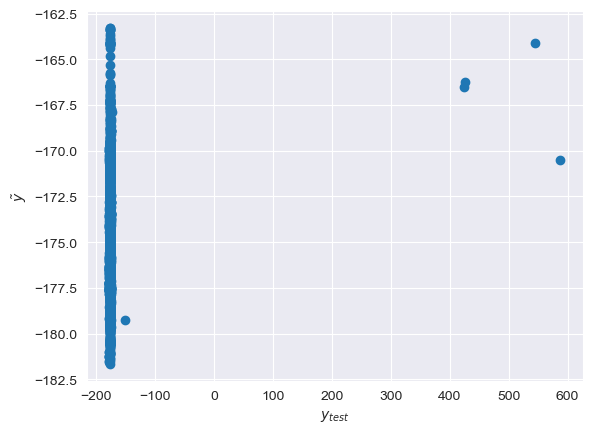

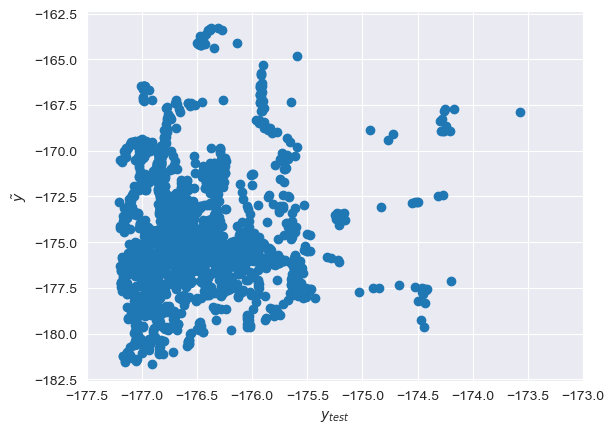

In [12]:
from sklearn.linear_model import LinearRegression

# On crée le modèle de régression linéaire

linear_regression = LinearRegression()

# On entraîne le modèle

linear_regression.fit(X_train, y_train)

# On prédit les énergies potentielles du jeu de test

y_pred = linear_regression.predict(X_test)

# On calcule le MSE et le RMSE

score = mean_squared_error(y_test, y_pred)


#RMSE
print(f" RMSE du modèle naïf : {np.sqrt(score)}")

#MAE

print(f" MAE du modèle naïf : {np.mean(np.abs(y_pred - y_test))}")

# get the Pearson correlation coefficient

from scipy.stats import pearsonr

corr, _ = pearsonr(y_test, y_pred)
print(' Pearsons correlation: %.3f' % corr)

# plot y_test vs y_pred

plt.scatter(y_test, y_pred)
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$\tilde{y}$')
plt.savefig('img/linear_regression/Mo2S4_full.png', dpi=200)
plt.show()

plt.scatter(y_test, y_pred)
plt.xlim(-177.5,-173)
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$\tilde{y}$')
plt.savefig('img/linear_regression/Mo2S4_zommed.png', dpi=200)
plt.show()

----- Naive model -----
 RMSE du modèle naïf : 0.5209878045162611
 MAE du modèle naïf : 0.38908037127255024
 Pearsons correlation: nan
----- Linear regression model -----
(10962, 18)
 Dimensions du jeu d'entraînement : (8769, 18)
 Dimensions du jeu de test : (2193, 18)
 Dimensions du jeu d'entraînement : (8769,)
 Dimensions du jeu de test : (2193,)
 RMSE du modèle naïf : 0.4228270539578531
 MAE du modèle naïf : 0.29612054544338423
 Pearsons correlation: 0.585
 Pearsons correlation^2: 0.342
None


C:\Users\lucas\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


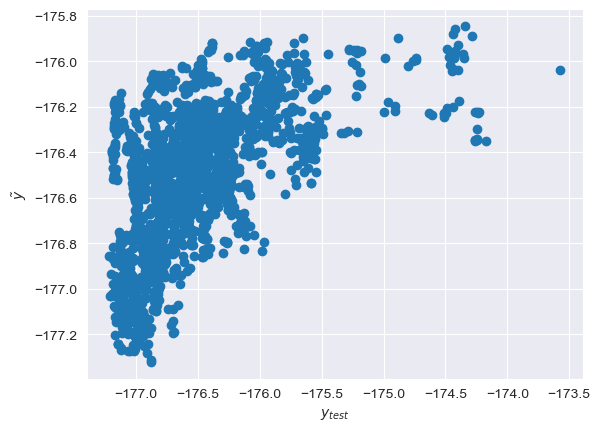

In [13]:
def filter_energy(X,y):

    y_mean = np.mean(y)
    y_std_value = np.std(y)
    
    y_std = []
    X_std = []
    
    for i in range(len(y)):
        if y_mean - y_std_value/2 < y[i] < y_mean + y_std_value/2:
            y_std.append(y[i])
            X_std.append(X[i])
    
    y_std = np.array(y_std)
    X_std = np.array(X_std)
    
    return X_std, y_std

X = get_liste_configurations_MO2S4()
X = X.reshape(11001, 18)
X_std, y_std = filter_energy(X,y)

# Naive model 

print("----- Naive model -----")

y_pred = np.full(len(y_std), np.mean(y_std))

score = mean_squared_error(y_std, y_pred)

#RMSE
print(f" RMSE du modèle naïf : {np.sqrt(score)}")

#MAE

print(f" MAE du modèle naïf : {np.mean(np.abs(y_pred - y_std))}")

# get the Pearson correlation coefficient

from scipy.stats import pearsonr

corr, _ = pearsonr(y_std, y_pred)
print(' Pearsons correlation: %.3f' % corr)

# Linear regression model

print("----- Linear regression model -----")

# On sépare les données en un jeu d'entraînement et un jeu de test

print(X_std.shape)
X_train, X_test, y_train, y_test = train_test_split(X_std, y_std, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f" Dimensions du jeu d'entraînement : {X_train.shape}"
      f"\n Dimensions du jeu de test : {X_test.shape}"
      f"\n Dimensions du jeu d'entraînement : {y_train.shape}"
      f"\n Dimensions du jeu de test : {y_test.shape}")   

# On crée le modèle de régression linéaire

linear_regression = LinearRegression()

# On entraîne le modèle

linear_regression.fit(X_train, y_train)

# On prédit les énergies potentielles du jeu de test

y_pred = linear_regression.predict(X_test)

# On calcule le MSE et le RMSE

score = mean_squared_error(y_test, y_pred)


#RMSE
print(f" RMSE du modèle naïf : {np.sqrt(score)}")

#MAE

print(f" MAE du modèle naïf : {np.mean(np.abs(y_pred - y_test))}")

# get the Pearson correlation coefficient

from scipy.stats import pearsonr

corr, _ = pearsonr(y_test, y_pred)
print(' Pearsons correlation: %.3f' % corr)
print(print(' Pearsons correlation^2: %.3f' % corr**2))

# plot y_test vs y_pred

plt.scatter(y_test, y_pred)
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$\tilde{y}$')
plt.savefig('img/linear_regression/filtered_Mo2S4_full.png', dpi=200)
plt.show()

<br>

We notice that we have reduced the MSE, but not by much. Therefore, we can deduce that the linear regression model is not suitable for this problem. The question then arises whether the issue lies with the model or the data. We will attempt to improve the data to see if the model performs better.

It's also worth noting that in this case, we do not differentiate between atoms by their type; we only consider the positions of the atoms. However, since the atom indices remain the same in the ``TRAJEC_short.xyz`` file, we can assume that their types are determined accordingly.

<br>

#### Again with Zundel Ions <a class="anchor" id="again-with-zundel-ions"></a>

We will repeat the same process for the Zundel ions.


In [14]:
# data : zundel_file_content (7 lignes par configuration, séparés par 2 lignes, commence à ligne 3)

def get_liste_configurations_zundel():
    liste_configurations = []
    
    for i in range(2, len(zundel_file_content), 9):
        configuration = []
        for j in range(7):
            configuration.append(zundel_file_content[i+j].split()[1:])
        liste_configurations.append(configuration)
    
    liste_configurations = np.array(liste_configurations, dtype=float)
    
    return liste_configurations

liste_configurations = get_liste_configurations_zundel()

print(liste_configurations.shape)

print(f" Nombres de configurations : {len(liste_configurations)}"
      f"\n Dimensions de la première configuration : {liste_configurations[0].shape}"
      f"\n Première configuration : \n {liste_configurations[0]}"
      f"\n Moyenne des positions des configurations : \n {np.mean(liste_configurations, axis=0)}"
      f"\n Ecart-type des positions des configurations : \n {np.std(liste_configurations, axis=0)}"
      f"\n Minimum des positions des configurations : \n {np.min(liste_configurations, axis=0)}"
      f"\n Maximum des positions des configurations : \n {np.max(liste_configurations, axis=0)}")


(10000, 7, 3)
 Nombres de configurations : 10000
 Dimensions de la première configuration : (7, 3)
 Première configuration : 
 [[ 2.24643327e+00  1.21709100e-02  8.47437000e-03]
 [-2.25776180e+00  1.15926000e-03  2.68762000e-03]
 [ 7.90166000e-03 -1.38440000e-03  1.29170760e-01]
 [-3.01260594e+00  1.47988102e+00 -7.37079700e-01]
 [-3.20407528e+00 -4.70426980e-01  1.48716647e+00]
 [ 2.99892402e+00 -1.48736113e+00 -7.45110910e-01]
 [ 3.20703656e+00  4.59307860e-01  1.50818372e+00]]
 Moyenne des positions des configurations : 
 [[13.58709477 10.80532464 16.63371386]
 [12.90282022 11.00889989 16.81197951]
 [13.24520615 10.90625441 16.72222114]
 [12.74901223 10.99485649 16.86820237]
 [12.79289672 11.10661123 16.80769024]
 [13.75640195 10.73154071 16.58435605]
 [13.68476702 10.78434803 16.61398254]]
 Ecart-type des positions des configurations : 
 [[ 8.00505693  4.88217814  8.80208969]
 [ 7.94208975  4.03652228  9.92605052]
 [ 7.88307837  4.28546715  9.28615869]
 [ 8.0144467   4.04638215 10.

In [15]:
# On peut maintenant récupérer les énergies

def get_energies_zundel():
    energies = []
    
    for i in range(len(zundel_potential_energy)):
        energies.append(zundel_potential_energy['potential_energy'][i])
    
    energies = np.array(energies, dtype=float)
    
    return energies

energies = get_energies_zundel()

print(f" Nombres d'énergies : {len(energies)}"
      f"\n Première énergie : {energies[0]:.2e}"
      f"\n Dernière énergie : {energies[-1]:.2e}"
      f"\n Moyenne des énergies : {np.mean(energies):.2e}"
      f"\n Ecart-type des énergies : {np.std(energies):.2e}"
      f"\n Minimum des énergies : {np.min(energies):.2e}, indice : {np.argmin(energies)}"
      f"\n Maximum des énergies : {np.max(energies):.2e}, indice : {np.argmax(energies)}")


 Nombres d'énergies : 10000
 Première énergie : 9.59e-05
 Dernière énergie : 2.19e-03
 Moyenne des énergies : 2.54e-03
 Ecart-type des énergies : 9.10e-04
 Minimum des énergies : 9.59e-05, indice : 0
 Maximum des énergies : 7.21e-03, indice : 752


In [16]:
# On peut maintenant créer un modèle naïf qui va prédire la moyenne des énergies potentielles

X = liste_configurations
y = energies

y_pred = np.full(len(energies), np.mean(energies))

score = mean_squared_error(energies, y_pred)

# RMSE en écriture scientifique
print(f" RMSE du modèle naïf : {np.sqrt(score):.2e}")
# MAE
print(f" MAE du modèle naïf : {np.mean(np.abs(y_pred - energies)):.2e}")

 RMSE du modèle naïf : 9.10e-04
 MAE du modèle naïf : 7.19e-04


In [17]:
from sklearn.model_selection import train_test_split

# On sépare les données en un jeu d'entraînement et un jeu de test

print(X.shape)
flattened_X = X.reshape(10000, 21)
print(flattened_X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(flattened_X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f" Dimensions du jeu d'entraînement : {X_train.shape}"
      f"\n Dimensions du jeu de test : {X_test.shape}"
      f"\n Dimensions du jeu d'entraînement : {y_train.shape}"
      f"\n Dimensions du jeu de test : {y_test.shape}")


(10000, 7, 3)
(10000, 21)
(10000,)
 Dimensions du jeu d'entraînement : (8000, 21)
 Dimensions du jeu de test : (2000, 21)
 Dimensions du jeu d'entraînement : (8000,)
 Dimensions du jeu de test : (2000,)


 RMSE du modèle naïf : 9.16e-04
 MAE du modèle naïf : 7.24e-04
 Pearsons correlation: 0.004


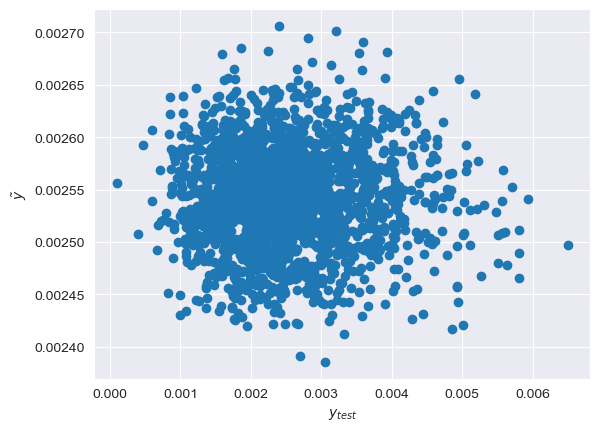

In [18]:
from sklearn.linear_model import LinearRegression

# On crée le modèle de régression linéaire

linear_regression = LinearRegression()

# On entraîne le modèle

linear_regression.fit(X_train, y_train)

# On prédit les énergies potentielles du jeu de test

y_pred = linear_regression.predict(X_test)

# On calcule le MSE et le RMSE

score = mean_squared_error(y_test, y_pred)

#RMSE
print(f" RMSE du modèle naïf : {np.sqrt(score):.2e}")

#MAE

print(f" MAE du modèle naïf : {np.mean(np.abs(y_pred - y_test)):.2e}")

# get the Pearson correlation coefficient

from scipy.stats import pearsonr

corr, _ = pearsonr(y_test, y_pred)
print(' Pearsons correlation: %.3f' % corr)

# plot y_test vs y_pred

plt.scatter(y_test, y_pred)
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$\tilde{y}$')
plt.savefig('img/linear_regression/zundel_full.png', dpi=200)
plt.show()

Here, we can observe that our linear model performs even worse than our naive model: $RMSE_{linear} = 9.15 \cdot 10^{-4}$ and $RMSE_{naive} = 9.09 \cdot 10^{-4}$.

However, the Persons correlation coefficient between predicted data and real data is very low.

The goal is to modify the data in order to be able to analyze it afterward.

### Describing the data with other representations <a class="anchor" id="describing-the-data-with-other-representations"></a>

<br>

BLabla

<br>

We will use the [Dscribe](https://singroup.github.io/dscribe/latest/) package to describe the data with other representations.

<br>


In [19]:
# Not working with this version of numpy, see the generate_txt.ipynb file
"""
from dscribe.descriptors import CoulombMatrix
from ase.io import read

def get_atoms_from_xyz(xyz_file_path):
    # Read the atomic coordinates from the XYZ file
    atoms = read(xyz_file_path, format='xyz', index=':')
    return atoms

MO2S4_atoms = get_atoms_from_xyz('data/MO2S4/TRAJEC_short.xyz')
"""
print("nope")

nope



#### Coulomb matrix <a class="anchor" id="coulomb-matrix"></a>

<br>

The Coulomb matrix encodes the atomic species and interatomic distances of a finite system in a pair-wise, two-body matrix inspired by the form of the Coulomb potential. The elements of this matrix are given by :

$$ M_{ij} = \begin{cases} \frac{1}{2} Z_i^{2.4} & \text{if } i = j \\ \frac{Z_i Z_j}{|R_i - R_j|} & \text{if } i \neq j \end{cases} $$

where $Z_i$ is the atomic number of atom $i$ and $|R_i - R_j|$ is the Euclidian distance between atoms i and j.


In [20]:
"""
def get_coulomb_matrix(atoms):
    # Create a Coulomb matrix
    cm = CoulombMatrix(n_atoms_max=len(MO2S4_atoms[0]), permutation="sorted_l2")
    coulomb_matrix = cm.create(atoms)
    return coulomb_matrix

coulomb_matrix = get_coulomb_matrix(MO2S4_atoms[0])
coulomb_matrix_reshaped = coulomb_matrix.reshape((len(MO2S4_atoms[0]),len(MO2S4_atoms[0])))
# Print the Coulomb matrix on a heatmap with values inside the cells
plt.imshow(coulomb_matrix_reshaped, cmap="hot", interpolation="nearest")
plt.colorbar()

# Add a title
plt.title(f"Coulomb matrix for {MO2S4_atoms[0].get_chemical_formula()}")
plt.show()
"""
print("nope")

nope


We indeed succeed to form a matrix with the atomic species and interatomic distances of a finite system. I calculated the first two values of the matrix and they are correct.

<br>

#### Many-body tensor representation <a class="anchor" id="many-body-tensor-representation"></a>

<br>

Another type of representation is the many-body tensor representation (MBTR). It is a generalization of the Coulomb matrix, which is a special case of the many-body tensor representation.

In [21]:
from dscribe.descriptors import MBTR

#TODO

SystemError: initialization of _internal failed without raising an exception

#### SOAP <a class="anchor" id="soap"></a>

<br>

The Smooth Overlap of Atomic Positions (SOAP) is a local representation that can be used to describe the local environment of atoms in a system. It is based on the idea that the local environment around an atom can be expressed as a sum of spherical harmonics around that atom. The SOAP descriptor is a histogram of the spherical harmonics coefficients.

In [ ]:
from dscribe.descriptors import SOAP

#TODO

<br>

### Analysis with the Coulomb matrix <a class="anchor" id="analysis-with-the-coulomb-matrix"></a>

<br>

We will now try to use the Coulomb matrix to describe the data and see if it improves the model.

<br>

In [ ]:
import numpy as np

X = np.genfromtxt('data/txt/MO2S4.txt')
y = get_energies_MO2S4()


# Only take the configurations where the energy (y) is less or more than standard deviations from the mean of the energies, and only taking the X configurations that correspond to these energies (same indices)
    
X_std, y_std = filter_energy(X,y)
# describe y_std
print(f"y_std mean : {np.mean(y_std):.4e}"
      f"\ny_std std : {np.std(y_std):.4e}"
      f"\ny_std min : {np.min(y_std):.4e}"
      f"\ny_std max : {np.max(y_std):.4e}"
      # 25, 50, 75 percentiles
        f"\ny_std 25% : {np.percentile(y_std, 25):.4e}"
        f"\ny_std 50% : {np.percentile(y_std, 50):.4e}"
        f"\ny_std 75% : {np.percentile(y_std, 75):.4e}"
      f"\ny_std shape : {y_std.shape}"
      f"\nDifference : {y.shape[0] - y_std.shape[0]}")

print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")
print(f"X_std shape : {X_std.shape}")
print(f"y_std shape : {y_std.shape}")
print(f"Difference : {X.shape[0] - X_std.shape[0]}")

In [ ]:
# use of StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f" Dimensions du jeu d'entraînement : {X_train.shape}"
      f"\n Dimensions du jeu de test : {X_test.shape}"
      f"\n Dimensions du jeu d'entraînement : {y_train.shape}"
      f"\n Dimensions du jeu de test : {y_test.shape}")

In [ ]:
# On crée le modèle naif

y_pred = np.full(len(y_std), np.mean(y_std))

score = mean_squared_error(y_std, y_pred)

#RMSE

print(f" RMSE of naive model : {np.sqrt(score):.2e}")

#MAE

print(f" MAE of naive model : {np.mean(np.abs(y_pred - y_std)):.2e}")

corr, _ = pearsonr(y_std, y_pred)

print(' Pearsons correlation: %.3f' % corr)

In [ ]:
# On crée le modèle de régression linéaire

linear_regression = LinearRegression()

# On entraîne le modèle

linear_regression.fit(X_train, y_train)

# On prédit les énergies potentielles du jeu de test

y_pred = linear_regression.predict(X_test)

# On calcule le MSE et le RMSE

score = mean_squared_error(y_test, y_pred)

#RMSE

print(f" RMSE of linear model : {np.sqrt(score)}")

#MAE

print(f" MAE of linear model : {np.mean(np.abs(y_pred - y_test))}")

corr, _ = pearsonr(y_test, y_pred)
print(' Pearsons correlation: %.3f' % corr)
print(print(' Pearsons correlation^2: %.3f' % corr**2))

# plot y_test vs y_pred

plt.scatter(y_test, y_pred)
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$\tilde{y}$')
plt.savefig('img/linear_regression/coulomb_MO2S4_full.png', dpi=200)
plt.show()

In [77]:
# Création du modèle
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense

cb_sauvegarde = ModelCheckpoint(filepath='save/coulomb_mo2s4_SGD.keras', save_best_only=True)

model = Sequential()

model.add(Dense(units=18, activation='relu', input_shape=(36,)))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.summary()

C:\Users\lucas\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 18)                │        666 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_40 (Dense)                │ (None, 8)                 │        152 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_41 (Dense)                │ (None, 1)                 │          9 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 827 (3.23 KB)

 Trainable params: 827 (3.23 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# let's train the model

from keras.optimizers import Adam

model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001,use_ema=True), metrics=['mse', 'mae'])

history = model.fit(X_train, y_train, epochs=1500, batch_size=32, verbose=1, validation_split=0.2,callbacks=[cb_sauvegarde])

# evaluate the model

scores = model.evaluate(X_test, y_test)

Epoch 1/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 31578.0605 - mae: 177.1579 - mse: 31578.0605 - val_loss: 31755.8379 - val_mae: 177.1026 - val_mse: 31755.8379
Epoch 2/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31332.8809 - mae: 176.4610 - mse: 31332.8809 - val_loss: 31496.2949 - val_mae: 176.3583 - val_mse: 31496.2949
Epoch 3/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31332.4316 - mae: 176.0148 - mse: 31332.4316 - val_loss: 31172.2930 - val_mae: 175.4243 - val_mse: 31172.2930
Epoch 4/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30594.1289 - mae: 174.4669 - mse: 30594.1289 - val_loss: 30759.2461 - val_mae: 174.2252 - val_mse: 30759.2461
Epoch 5/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30265.1621 - mae: 173.4235 - mse: 30265.1621 - val_loss: 30231.7363 - val_mae: 172.6790 - val_mse: 30231.7363
Epoch 6/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29942.0781 - mae: 172.0608 - mse: 29942.0781 - val_loss: 29563.5449 - val_mae:

KeyboardInterrupt: 

Score du modèle: [0.039644282311201096, 0.1406346559524536, 0.039644282311201096]
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
 Pearsons correlation: 0.026


C:\Users\lucas\AppData\Local\Temp\ipykernel_14700\3611301250.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(' Pearsons correlation: %.3f' % corr)


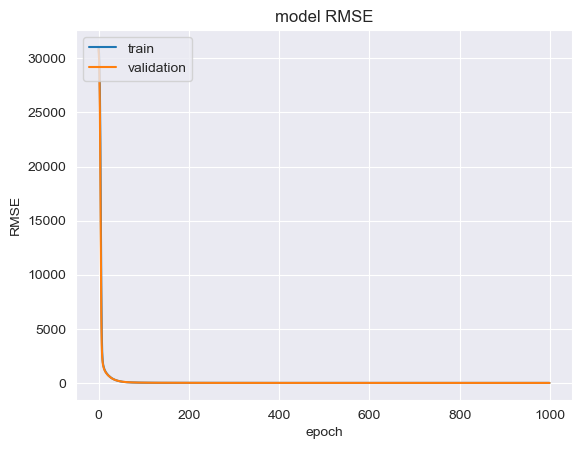

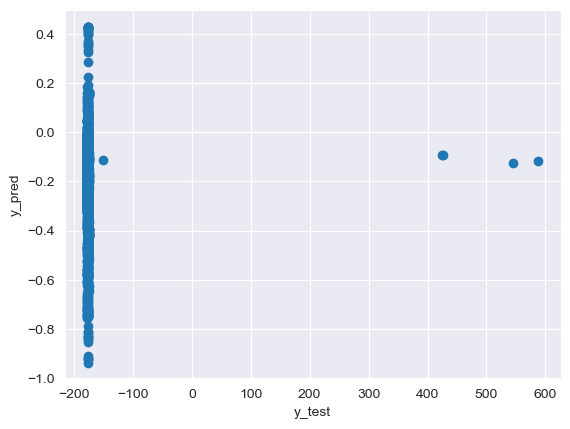

In [70]:


# resulsts and graph of history for RMSE

print(f"Score du modèle: {scores}")

# pearson correlation

y_pred = model.predict(X_test)

corr, _ = pearsonr(y_test, y_pred)

print(' Pearsons correlation: %.3f' % corr)

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# afficher les valeurs prédites en fonction des valeurs réelles

plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()


In [75]:
# use of StandardScaler

X = np.genfromtxt('data/txt/MO2S4.txt')
y = get_energies_MO2S4()

X_std, y_std = filter_energy(X,y)

X, y = X_std, y_std

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f" Dimensions du jeu d'entraînement : {X_train.shape}"
      f"\n Dimensions du jeu de test : {X_test.shape}"
      f"\n Dimensions du jeu d'entraînement : {y_train.shape}"
      f"\n Dimensions du jeu de test : {y_test.shape}")

 Dimensions du jeu d'entraînement : (8769, 36)
 Dimensions du jeu de test : (2193, 36)
 Dimensions du jeu d'entraînement : (8769,)
 Dimensions du jeu de test : (2193,)


 RMSE of linear model : 2.72e-01
 MAE of linear model : 2.01e-01
 Pearsons correlation: 0.853
 Pearsons correlation^2: 0.728
None


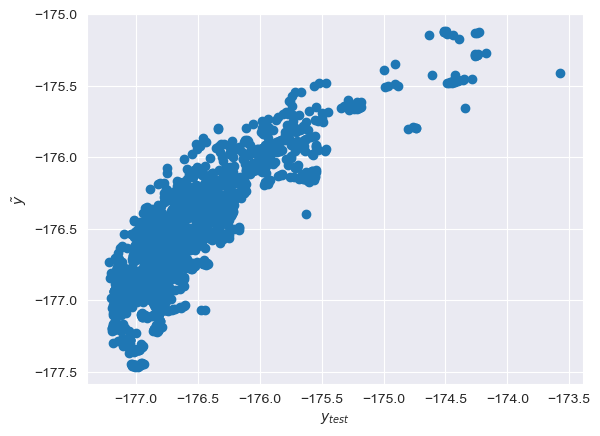

In [76]:
# On crée le modèle de régression linéaire

linear_regression = LinearRegression()

# On entraîne le modèle

linear_regression.fit(X_train, y_train)

# On prédit les énergies potentielles du jeu de test

y_pred = linear_regression.predict(X_test)

# On calcule le MSE et le RMSE

score = mean_squared_error(y_test, y_pred)

#RMSE

print(f" RMSE of linear model : {np.sqrt(score):.2e}")

#MAE

print(f" MAE of linear model : {np.mean(np.abs(y_pred - y_test)):.2e}")

corr, _ = pearsonr(y_test, y_pred)
print(' Pearsons correlation: %.3f' % corr)
print(print(' Pearsons correlation^2: %.3f' % corr**2))

# plot y_test vs y_pred

plt.scatter(y_test, y_pred)
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$\tilde{y}$')
plt.savefig('img/linear_regression/coulomb_filtered_MO2S4_full.png', dpi=200)
plt.show()

 RMSE of linear model : 7.98e+01
 MAE of linear model : 6.32e+01
 Pearsons correlation: 0.489
 Pearsons correlation^2: 0.239
None


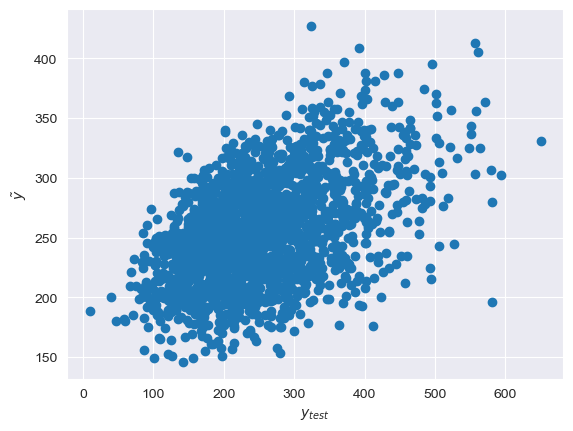

In [55]:
# On crée le modèle de régression linéaire pour zundel en coulomb

X = np.genfromtxt('data/txt/zundel.txt')
y = get_energies_zundel()*(10**5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_regression = LinearRegression()

# On entraîne le modèle

linear_regression.fit(X_train, y_train)

# On prédit les énergies potentielles du jeu de test

y_pred = linear_regression.predict(X_test)

# On calcule le MSE et le RMSE

score = mean_squared_error(y_test, y_pred)

#RMSE

print(f" RMSE of linear model : {np.sqrt(score):.2e}")

#MAE

print(f" MAE of linear model : {np.mean(np.abs(y_pred - y_test)):.2e}")

corr, _ = pearsonr(y_test, y_pred)
print(' Pearsons correlation: %.3f' % corr)
print(print(' Pearsons correlation^2: %.3f' % corr**2))

# plot y_test vs y_pred

plt.scatter(y_test, y_pred)
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$\tilde{y}$')
plt.savefig('img/linear_regression/coulomb_zundel_full.png', dpi=200)
plt.show()

In [33]:
# Création du modèle
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

cb_sauvegarde = ModelCheckpoint(filepath='save/coulomb_zundel_Adam_normal.keras', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.0001)

model = Sequential()

model.add(Dense(units=18, activation='relu', input_shape=(49,)))
model.add(Dense(units=18, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.summary()

C:\Users\lucas\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 18)                │        900 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 18)                │        342 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 8)                 │        152 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 1)                 │          9 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,403 (5.48 KB)

 Trainable params: 1,403 (5.48 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# let's train the model

from keras.optimizers import SGD,Adam

X = np.genfromtxt('data/txt/zundel.txt')
y = get_energies_zundel()*100000

print(np.mean(y))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Utiliser l'optimiseur SGD avec un momentum
optimiseur = Adam(learning_rate=0.00005)

model.compile(loss='mse', optimizer=optimiseur, metrics=['mse','mae'])

253.82573166967


In [ ]:


history = model.fit(X_train, y_train, epochs=2000, batch_size=32, verbose=1, validation_split=0.2,callbacks=[cb_sauvegarde,early_stopping])

# evaluate the model

scores = model.evaluate(X_test, y_test)

Epoch 1/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5128.8594 - mae: 56.8879 - mse: 5128.8594 - val_loss: 5847.3105 - val_mae: 58.8944 - val_mse: 5847.3105
Epoch 2/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5025.0278 - mae: 55.9909 - mse: 5025.0278 - val_loss: 5846.5127 - val_mae: 58.8805 - val_mse: 5846.5127
Epoch 3/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5107.2021 - mae: 56.5407 - mse: 5107.2021 - val_loss: 5847.0630 - val_mae: 58.8520 - val_mse: 5847.0630
Epoch 4/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5347.9131 - mae: 57.5774 - mse: 5347.9131 - val_loss: 5843.0273 - val_mae: 58.8533 - val_mse: 5843.0273
Epoch 5/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5104.6045 - mae: 56.7205 - mse: 5104.6045 - val_loss: 5840.7632 - val_mae: 58.8728 - val_mse: 5840.7632
Epoch 6/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5162.1509 - mae: 56.8824 - mse: 5162.1509 - val_loss: 5838.2227 - val_mae: 58.8920 - val_mse: 5838.2227
Epoc

RMSE du modèle: 73.49659191715966
MAE du modèle: 57.89897155761719
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
 Pearsons correlation: 0.595
 Pearsons correlation^2: 0.354
None


C:\Users\lucas\AppData\Local\Temp\ipykernel_10736\354846094.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(' Pearsons correlation: %.3f' % corr)
C:\Users\lucas\AppData\Local\Temp\ipykernel_10736\354846094.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(print(' Pearsons correlation^2: %.3f' % corr**2))


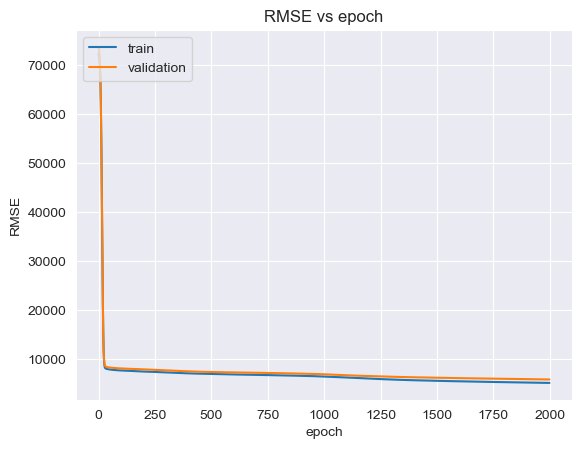

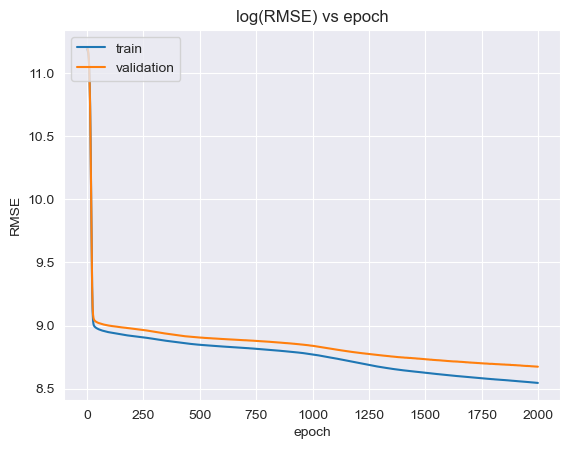

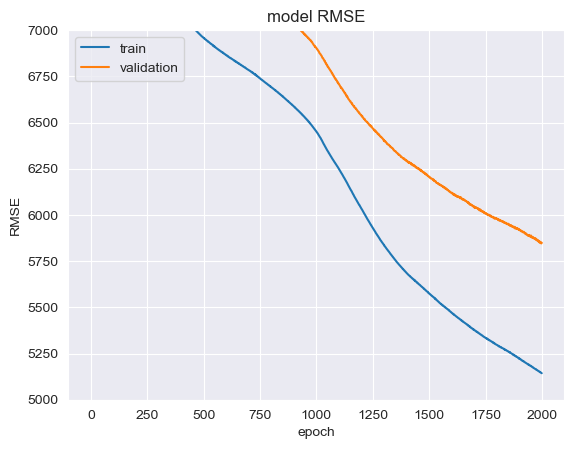

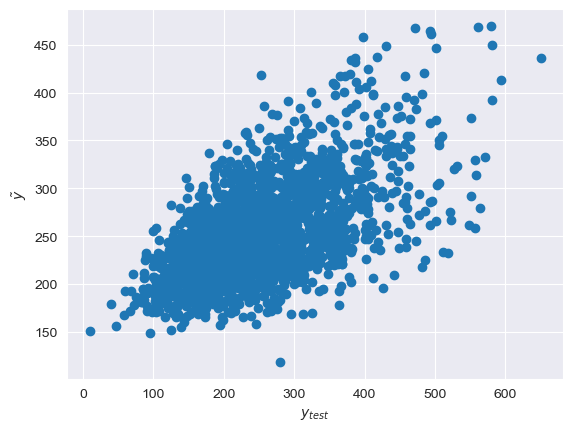

In [38]:
# resulsts and graph of history for RMSE

RMSE = np.sqrt(scores[0])

print(f"RMSE du modèle: {RMSE}")

MAE = scores[1]

print(f"MAE du modèle: {MAE}")

# pearson correlation

y_pred = model.predict(X_test)

corr, _ = pearsonr(y_test, y_pred)

print(' Pearsons correlation: %.3f' % corr)
print(print(' Pearsons correlation^2: %.3f' % corr**2))

# mse and val_me but logarithmic scale vs epoch

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('RMSE vs epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('img/nn/coulomb_zundel_Adam_epoch_1000_mse.png', dpi=200)
plt.show()

plt.plot(np.log(history.history['mse']),'-')
plt.plot(np.log(history.history['val_mse']),'-')
plt.title('log(RMSE) vs epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('img/nn/coulomb_zundel_Adam_epoch_1000_logmse.png', dpi=200)
plt.show()
    
plt.plot(history.history['mse'],'-')
plt.plot(history.history['val_mse'],'-')
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(5000,7000)
plt.savefig('img/nn/coulomb_zundel_Adam_epoch_1000_mse_zoomed.png', dpi=200)
plt.show()

# afficher les valeurs prédites en fonction des valeurs réelles

plt.scatter(y_test, y_pred)
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$\tilde{y}$')
plt.savefig('img/nn/coulomb_zundel_Adam_full.png', dpi=200)
plt.show()

In [22]:
# Création du modèle
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

cb_sauvegarde = ModelCheckpoint(filepath='save/filtered_coulomb_mo2s4_Adam_normal.keras', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.0001)

model = Sequential()

model.add(Dense(units=18, activation='relu', input_shape=(36,)))
model.add(Dense(units=18, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.summary()

C:\Users\lucas\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 18)                │        666 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 18)                │        342 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 8)                 │        152 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 1)                 │          9 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# let's train the model

from keras.optimizers import SGD,Adam

X = np.genfromtxt('data/txt/MO2S4.txt')
y = get_energies_MO2S4()

X_std, y_std = filter_energy(X,y)

X, y = X_std, y_std

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Utiliser l'optimiseur SGD avec un momentum
optimiseur = Adam(learning_rate=0.00005)

model.compile(loss='mse', optimizer=optimiseur, metrics=['mse', 'mae'])

In [28]:
history = model.fit(X_train, y_train, epochs=2000, batch_size=32, verbose=1, validation_split=0.2,callbacks=[cb_sauvegarde,early_stopping])

# evaluate the model

scores = model.evaluate(X_test, y_test)

Epoch 1/2000
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 26830.9902 - mae: 163.7358 - mse: 26830.9902 - val_loss: 26079.3750 - val_mae: 161.4037 - val_mse: 26079.3750
Epoch 2/2000
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25797.7930 - mae: 160.5169 - mse: 25797.7930 - val_loss: 24870.0801 - val_mae: 157.5702 - val_mse: 24870.0801
Epoch 3/2000
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24524.7754 - mae: 156.4519 - mse: 24524.7754 - val_loss: 23340.7031 - val_mae: 152.5731 - val_mse: 23340.7031
Epoch 4/2000
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22972.6602 - mae: 151.3335 - mse: 22972.6602 - val_loss: 21485.4746 - val_mae: 146.2617 - val_mse: 21485.4746
Epoch 5/2000
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21014.6348 - mae: 144.5847 - mse: 21014.6348 - val_loss: 19311.2617 - val_mae: 138.4631 - val_mse: 19311.2617
Epoch 6/2000
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18782.0020 - mae: 136.4452 - mse: 18782.0020 - val_loss: 16868.2188 - val_mae:

RMSE du modèle: 0.11478180025396188
MAE du modèle: 0.08554390072822571
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 Pearsons correlation: 0.979
 Pearsons correlation^2: 0.958
None


C:\Users\lucas\AppData\Local\Temp\ipykernel_10736\2312685402.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(' Pearsons correlation: %.3f' % corr)
C:\Users\lucas\AppData\Local\Temp\ipykernel_10736\2312685402.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(print(' Pearsons correlation^2: %.3f' % corr**2))


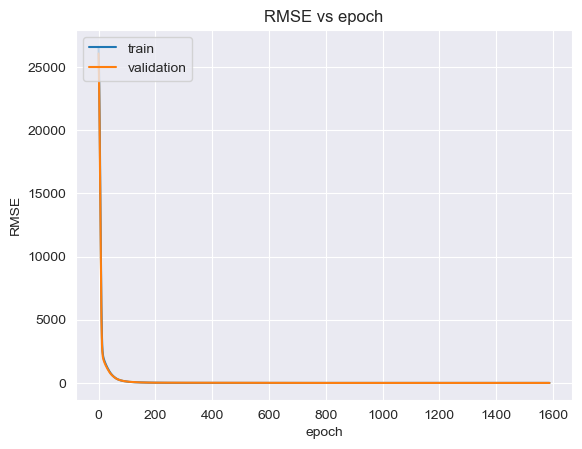

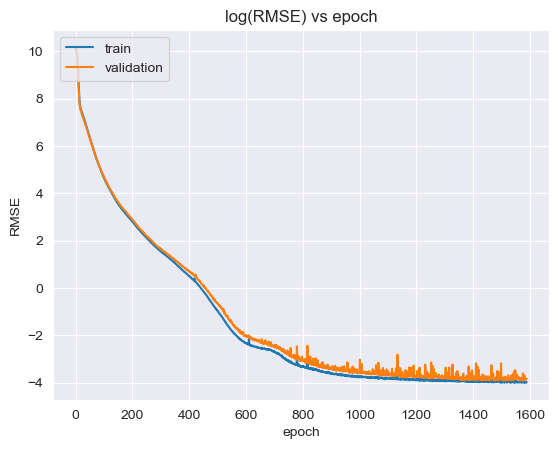

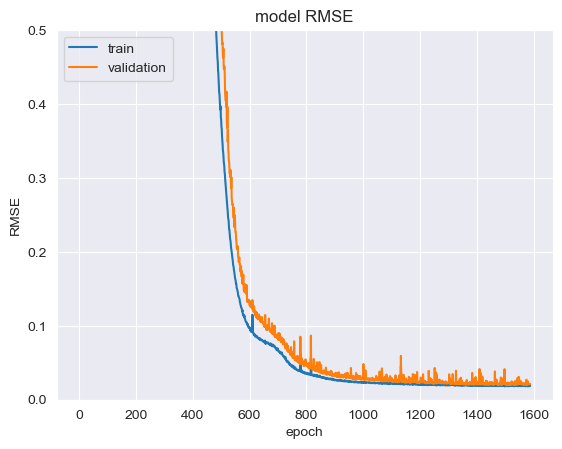

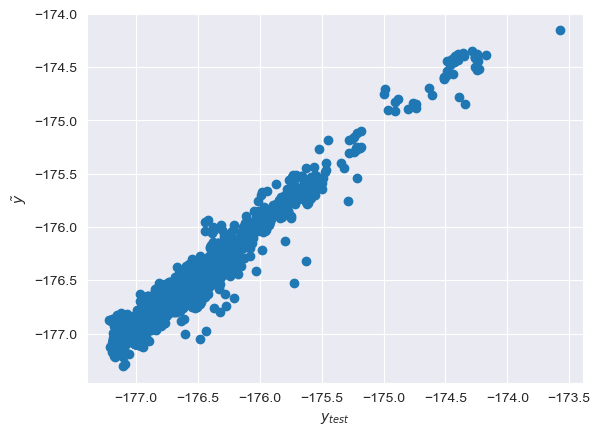

In [29]:
# resulsts and graph of history for RMSE

RMSE = np.sqrt(scores[0])

print(f"RMSE du modèle: {RMSE}")

MAE = scores[1]

print(f"MAE du modèle: {MAE}")

# pearson correlation

y_pred = model.predict(X_test)

corr, _ = pearsonr(y_test, y_pred)

print(' Pearsons correlation: %.3f' % corr)
print(print(' Pearsons correlation^2: %.3f' % corr**2))

# mse and val_me but logarithmic scale vs epoch

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('RMSE vs epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('img/nn/coulomb_mo2s4_Adam_epoch_1000_mse.png', dpi=200)
plt.show()

plt.plot(np.log(history.history['mse']),'-')
plt.plot(np.log(history.history['val_mse']),'-')
plt.title('log(RMSE) vs epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('img/nn/coulomb_mo2s4_Adam_epoch_1000_logmse.png', dpi=200)
plt.show()
    
plt.plot(history.history['mse'],'-')
plt.plot(history.history['val_mse'],'-')
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(0,0.5)
plt.savefig('img/nn/coulomb_mo2s4_Adam_epoch_1000_mse_zoomed.png', dpi=200)
plt.show()

# afficher les valeurs prédites en fonction des valeurs réelles

plt.scatter(y_test, y_pred)
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'$\tilde{y}$')
plt.savefig('img/nn/coulomb_mo2s4_Adam_full.png', dpi=200)
plt.show()

In [163]:
# Création du modèle
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense

cb_sauvegarde = ModelCheckpoint(filepath='save/coulomb_mo2s4_Adam_over.keras', save_best_only=True)

model = Sequential()

model.add(Dense(units=18, activation='relu', input_shape=(36,)))
model.add(Dense(units=18, activation='relu'))
model.add(Dense(units=18, activation='relu'))
model.add(Dense(units=18, activation='relu'))

model.add(Dense(units=1, activation='linear'))

model.summary()

C:\Users\lucas\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 18)                │        666 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_97 (Dense)                │ (None, 18)                │        342 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_98 (Dense)                │ (None, 18)                │        342 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_99 (Dense)                │ (None, 1)                 │         19 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,369 (5.35 KB)

 Trainable params: 1,369 (5.35 KB)

 Non-trainable params: 0 (0.00 B)

In [164]:
# let's train the model

# Utiliser l'optimiseur SGD avec un momentum
optimiseur = Adam(learning_rate=0.0001)

model.compile(loss='mse', optimizer=optimiseur, metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, epochs=1500, batch_size=32, verbose=1, validation_split=0.2,callbacks=[cb_sauvegarde])

# evaluate the model

scores = model.evaluate(X_test, y_test)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 18)                │        666 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_97 (Dense)                │ (None, 18)                │        342 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_98 (Dense)                │ (None, 18)                │        342 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_99 (Dense)                │ (None, 1)                 │         19 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,369 (5.35 KB)

 Trainable params: 1,369 (5.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 30806.3047 - mae: 175.5148 - mse: 30806.3047 - val_loss: 30362.4980 - val_mae: 174.2436 - val_mse: 30362.4980
Epoch 2/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30143.7051 - mae: 173.6112 - mse: 30143.7051 - val_loss: 29211.2969 - val_mae: 170.8917 - val_mse: 29211.2969
Epoch 3/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28756.6074 - mae: 169.5390 - mse: 28756.6074 - val_loss: 27014.6504 - val_mae: 164.2618 - val_mse: 27014.6504
Epoch 4/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26279.4570 - mae: 161.9472 - mse: 26279.4570 - val_loss: 23383.5195 - val_mae: 152.5396 - val_mse: 23383.5195
Epoch 5/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22231.0508 - mae: 148.5199 - mse: 22231.0508 - val_loss: 18074.8086 - val_mae: 133.1824 - val_mse: 18074.8086
Epoch 6/1500
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16588.6348 - mae: 126.9669 - mse: 16588.6348 - val_loss: 11866.5264 - val_mae:

Score du modèle: [0.019735420122742653, 0.10362047702074051, 0.019735420122742653]
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 Pearsons correlation: 0.961


C:\Users\lucas\AppData\Local\Temp\ipykernel_32100\3827886826.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(' Pearsons correlation: %.3f' % corr)


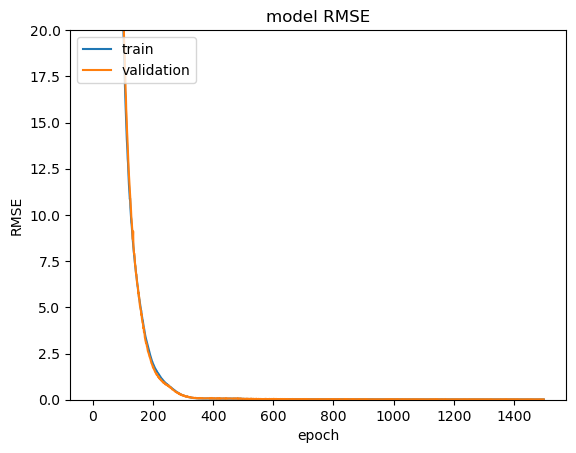

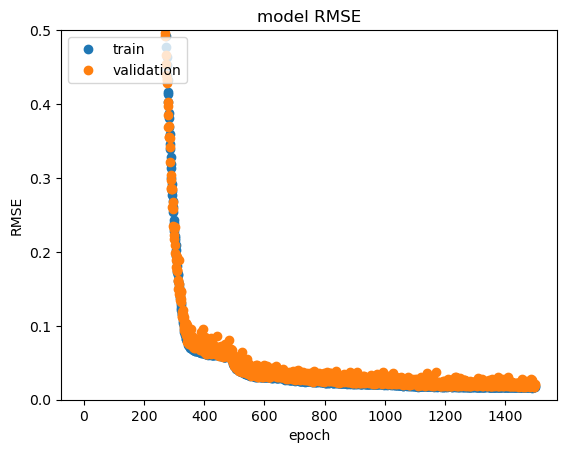

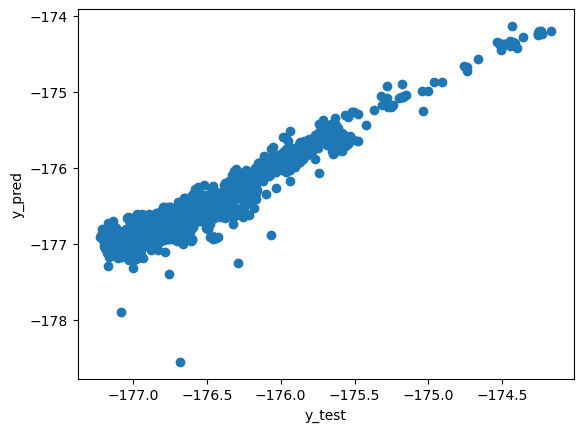

In [165]:


# resulsts and graph of history for RMSE

print(f"Score du modèle: {scores}")

# pearson correlation

y_pred = model.predict(X_test)

corr, _ = pearsonr(y_test, y_pred)

print(' Pearsons correlation: %.3f' % corr)

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(0,20)
plt.show()
    
plt.plot(history.history['mse'],'o')
plt.plot(history.history['val_mse'],'o')
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(0,0.5)
plt.show()

# afficher les valeurs prédites en fonction des valeurs réelles

plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()